In [1]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifiers 
from sklearn.naive_bayes import GaussianNB

# Analysis libs
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

In [2]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [3]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Class
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [6]:
gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Training accuracy: 0.9927347197503474
Test accuracy: 0.9922066101598498


In [7]:
y_pred = clf.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Precision score: {precision_score(y_test, y_pred)}")
print(f"Recall score: {recall_score(y_test, y_pred)}")
print(f"F-1 score: {f1_score(y_test, y_pred)}")

Accuracy score: 0.9922066101598498
Precision score: 0.9887031179394488
Recall score: 0.9957901922858118
F-1 score: 0.9922340003401167


In [7]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm

array([[8690,  100],
       [  37, 8752]])

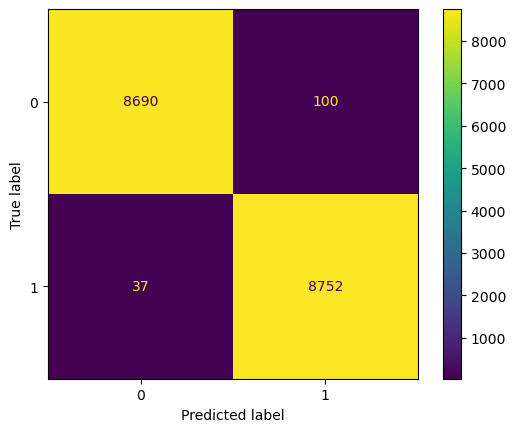

In [8]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8790
           1       0.99      1.00      0.99      8789

    accuracy                           0.99     17579
   macro avg       0.99      0.99      0.99     17579
weighted avg       0.99      0.99      0.99     17579



In [10]:
scores = cross_val_score(clf, X, y, cv=10)

In [11]:
print(f"Scores from CV: {scores}")
print(f"Mean of CV scores: {scores.mean()}")
print(f"Standard Deviation of CV scores: {scores.std()}")

Scores from CV: [0.99419795 0.99419795 0.98788396 0.98771331 0.98737201 0.99334471
 0.99283154 0.99385561 0.99436764 0.99539171]
Mean of CV scores: 0.9921156390186446
Standard Deviation of CV scores: 0.0029885846686455164


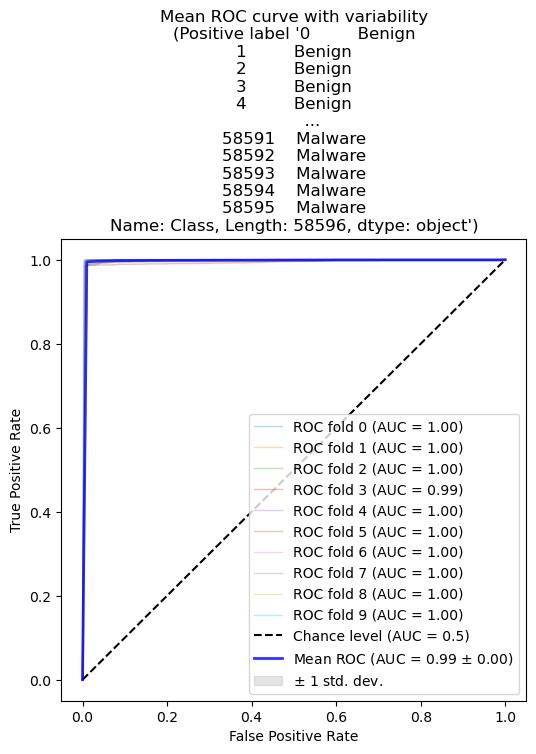

In [12]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
        gnb.fit(X.iloc[train], y[train])
        viz = RocCurveDisplay.from_estimator(
                gnb,
                X.iloc[test],
                y[test],
                name=f"ROC fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
                plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
)

ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label '{malware_data.Class}')",
)
ax.legend(loc="lower right")
plt.show()

### Report and results
In using the model GaussianNaiveBayes, we can see that the model did well in this task. What is interesting is that this model did not do as well as other models, but when it comes to training it takes little to no time for the model to train. Of course, time is not as important as this model did miss classify many samples, however the scores says this model did perform well. Additionally, the model is well defined when we see that ROC graphic with mostly perfect right angles.  